# Capstone Project: Battle of the Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

## Table of Contents

1. <a href="#item1">Introduction / Business Problem</a>    
2. <a href="#item2">Data</a>  
   2.1 <a href="#item21">Geo-Data for the neighborhoods in Munich</a>  
   2.2 <a href="#item22">FOURSQUARE Data of fitness centers in Munich</a>  
   2.3 <a href="#item23">Munich Population Statistics - OpenData</a>   
3. <a href="#item3">Methodology</a>
4. <a href="#item4">Results and Discussion</a> 
5. <a href="#item5">Conclusion</a> 

<a id = 'item1'></a>
## 1. Introduction / Business Problem

Target of this project is finding the most promising neighborhoods in Munich, Germany for opening new fitness centers.
Stakeholders are fitness trainers who want to start their own business or big fitness companies who want to expand their business within Munich.
The final result of this project is a single key indicator for the 25 districts of Munich which allows the stakeholders to identify the best location for their new business activities. This indicator does not only reflect the total number of existing gyms but also take into account different factors from the structure of the population in Munich (e.g. Population density, Age structure, unemployment rate, etc.).

##### *First download all required dependencies:*

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#pip install geopy
#pip install requests
#pip install Shapely

# import requsts
import requests

# import geopy distance
import geopy.distance

# import shape and Point from shapely
from shapely.geometry import shape, Point

print('Libraries imported.')

Libraries imported.


<a id = 'item2'></a>
## 2. Data

<a id = 'item21'></a>
### 2.1 Geo-Data for the neighborhoods in Munich
The geojson file for the Neighborhoods in Munich can be found here:
https://gist.github.com/webtobesocial/f8c1ea64b2862c6eda8771daba4f297b

Read the geojson file and create a dataframe for the Neighborhoods including coordinates of each neighborhood located by geopy:

In [2]:
# geojson file for the City Districts in Munich
munich_districts = r'muenchen_city_districts.geojson'

In [4]:
# read geojson file and get the coordinates of each City district
with open('muenchen_city_districts.geojson', 'r', encoding="utf-8") as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
# normalize the json data
districts = json_normalize(obj['features'])
id = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
districts = pd.concat([pd.DataFrame(id), districts[['properties.name']]], axis = 1)
# add latitude and longitude with geopy
lat =[]
long = []
geolocator = Nominatim(user_agent="m_explorer")

for i in range(len(districts)):
    address = districts.iloc[i,1]+',Munich, BY, Germany'
    location = geolocator.geocode(address)
    lat.append(location.latitude)
    long.append(location.longitude)
districts = pd.concat([districts, pd.DataFrame(lat), pd.DataFrame(long)], axis = 1)
districts.columns = ['NeighborhoodID', 'Neighborhood', 'Latitude', 'Longitude' ]
districts.head()

,NeighborhoodID,Neighborhood,Latitude,Longitude
0,01,Altstadt-Lehel,48.137828,11.574582
1,02,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809
2,03,Maxvorstadt,48.146570,11.571445
3,04,Schwabing-West,48.164417,11.570364
4,05,Au-Haidhausen,48.128753,11.590536


Define a function which finds the Neigborhood in Munich based on coordinates:

In [5]:
def findDistrict(filename, lat, long):
    # load GeoJSON file containing sectors
    with open(filename, encoding="utf-8") as f:
        js = json.load(f)

    # construct point based on lon/lat returned by geocoder
    point = Point(long, lat)

    # check each polygon to see if it contains the point
    for feature in js ['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']

#Example
findDistrict('muenchen_city_districts.geojson', 48.092385, 11.506933)

'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln'

get coordinates of Munich from Geopy:

In [6]:
# get coordinates of Munich City Center for the map
address = 'Munich, BY, Germany'
geolocator = Nominatim(user_agent="m_explorer")
location = geolocator.geocode(address)
munich_city_center = [location.latitude, location.longitude]
print('The geograpical coordinate of Munich are {}, {}.'.format(munich_city_center[0], munich_city_center[1]))

The geograpical coordinate of Munich are 48.1371079, 11.5753822.


Show the map of Munich including the Neighborhoods:

In [7]:
map_munich = folium.Map(location=munich_city_center, zoom_start=11)
folium.GeoJson(
    munich_districts,
    name='geojson'
).add_to(map_munich)

for lat, lng, Neighborhood, idt in zip(districts['Latitude'], districts['Longitude'], districts['Neighborhood'], districts['NeighborhoodID']):
    label = '{} -  {}'.format(idt, Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)  
    
map_munich

<a id = 'item22'></a>
### 2.2 FOURSQUARE Data of fitness centers in Munich
The geojson file for the Neighborhoods in Munich can be found here:
https://gist.github.com/webtobesocial/f8c1ea64b2862c6eda8771daba4f297b

Create a grid of coordinates for the FOURSQUARE search. This is necessary because in the free Version only 50 venues are delivered per search:

In [8]:
#create grid of coordinates for the foursquare search
lat_boundaries = [48.0602, 48.2503]
long_boundaries = [11.3605, 11.7231]
range_lat = np.arange(lat_boundaries[0], lat_boundaries[1], (lat_boundaries[1]-lat_boundaries[0])/21)
range_long = np.arange(long_boundaries[0], long_boundaries[1], (long_boundaries[1]-long_boundaries[0])/28)
grid = []
for i in range(len(range_lat)):
    for j in range(len(range_long)):
        if findDistrict('muenchen_city_districts.geojson', range_lat[i], range_long[j]) != None:
            grid.append([range_lat[i], range_long[j]])
len(grid)

318

Show the coordinates for the searches:

In [9]:
#show grid
map_grid = folium.Map(location=munich_city_center, zoom_start=11)
folium.GeoJson(
    munich_districts,
    name='geojson',
).add_to(map_grid)

for i in range(len(grid)):
        folium.CircleMarker(
        [grid[i][0], grid[i][1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_grid)  
    
map_grid

Define a function which adjusts the search radius based on the distance to the city center.
This is to improve the number of search results from FOURSQUARE

In [10]:
# set up a list for the distance of the grid coordinates to the city center
grid_distance = []
for i in range(len(grid)):
    grid_distance.append(geopy.distance.distance(munich_city_center, grid[i]).km)

# get the radius for the FOURSQUARE search depending on the distance to the city center (1000 - 2000 m)
def getRadius(min_dis, max_dis, dis):
    m = 1/(max_dis-min_dis)
    b = 2-(max_dis*m)
    return int((m*dis + b)*1000)

FOURSQUARE credentials:

In [11]:
CLIENT_ID = 'FU3BMTIVBL031OXHOUISHFDWHZTYE11PAUQOT0U34TR5QXTE' # your Foursquare ID
CLIENT_SECRET = 'B2JY1AKRVX2UD14F3G52CYIJWZH0OKLKVLNGVAY0YUGJM5RH' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FU3BMTIVBL031OXHOUISHFDWHZTYE11PAUQOT0U34TR5QXTE
CLIENT_SECRET:B2JY1AKRVX2UD14F3G52CYIJWZH0OKLKVLNGVAY0YUGJM5RH


FOURSQUARE Search and Process of the Fitness centers:

In [22]:
table = None
search_query = ''
for idx in range(len(grid)):
    # built foursquare search query for the grid coordinates
    categoryId = '4bf58dd8d48988d175941735'  # fitness group category only
    # set radius for search depending on grid-point distance to city center
    radius = getRadius(min(grid_distance), max(grid_distance), grid_distance[idx])
    latitude = grid[idx][0]
    longitude = grid[idx][1]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&intent=browse&query={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, categoryId, radius, LIMIT)
    
    # receive venues from foursquare
    results = requests.get(url).json()
        
    try:
         # tranform results into a dataframe
         venues = json_normalize(results['response']['venues'])
    
         # read categories of the venues into separate dataframe
         categories = json_normalize(results['response']['venues'], record_path='categories', meta=['id'], record_prefix='category.')
    
         # merge venues- and categories- Dataframe
         tmp = pd.merge(venues[['id', 'name', 'location.city', 'location.lat', 'location.lng']], categories[['id', 'category.id', 'category.name']], on='id', how='outer')
         table = pd.concat([table, tmp])
    except: 
        #some search coordinates do not have fitness centers
        print('Grid-Row:', idx, grid_distance[idx], radius )
        
  

Grid-Row: 38 9.283601324807023 1574
Grid-Row: 56 8.836109250040732 1544
Grid-Row: 166 14.286463569939917 1906
Grid-Row: 212 7.9607343228048775 1486
Grid-Row: 213 8.834855993395777 1544
Grid-Row: 234 8.454471551474448 1519
Grid-Row: 235 9.282073866858783 1574
Grid-Row: 238 12.467188712624495 1785
Grid-Row: 255 13.78471265887451 1873
Grid-Row: 256 12.945089907790049 1817
Grid-Row: 261 9.121294602053629 1563
Grid-Row: 273 12.694991331222672 1800
Grid-Row: 277 9.868324319455262 1613
Grid-Row: 278 9.277814129546934 1573
Grid-Row: 292 10.11395269426044 1629
Grid-Row: 303 10.978736529775182 1686
Grid-Row: 308 9.583598686873556 1594
Grid-Row: 313 11.865904715050469 1745
Grid-Row: 314 11.460986101139758 1718
Grid-Row: 315 11.124892471111176 1696
Grid-Row: 316 12.770793454959003 1805
Grid-Row: 317 12.395537036239341 1781


In [23]:
print('Number of returned venues: ',len(table))

Number of returned venues:  3041


Remove duplicates:

In [24]:
table.drop_duplicates(inplace = True)
table.sort_values('id', inplace = True)
table.reset_index(drop=True, inplace = True)
print('Number of unique venues: ',len(table))

Number of unique venues:  655


Filter the Fitness Centers:  
Search category 'Fitness center' has several subcategories which are not in interest (e.g. Yogastudio, Martial Arts, etc.)

In [25]:
lst_cat = ['4bf58dd8d48988d175941735', '4bf58dd8d48988d176941735', '52f2ab2ebcbc57f1066b8b48']
#'4bf58dd8d48988d175941735' = Fitness Center
#'4bf58dd8d48988d176941735' = Gym 
#'52f2ab2ebcbc57f1066b8b48' = Gymnastic Gym
table_new = table[table['category.id'].isin(lst_cat)]
table_new.reset_index(drop=True, inplace = True)
table_new.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name
0,4ade0d28f964a5201b6b21e3,Kieser Training,München,48.161105,11.568546,4bf58dd8d48988d175941735,Gym / Fitness Center
1,4b25f21af964a520ab7724e3,BS Sporthalle,München,48.180263,11.536702,4bf58dd8d48988d176941735,Gym
2,4b476e72f964a520d83126e3,körperLOUNGE,München,48.146972,11.560949,4bf58dd8d48988d175941735,Gym / Fitness Center
3,4b4a5253f964a520c98326e3,McFIT,München,48.108272,11.580093,4bf58dd8d48988d175941735,Gym / Fitness Center
4,4b4b6361f964a520c79926e3,Fitness First Black Label Club,München,48.137731,11.571460,4bf58dd8d48988d175941735,Gym / Fitness Center


In [32]:
print('Number of unique Fitness Center: ',len(table))

Number of unique Fitness Center:  655


Write data to disc:

In [27]:
table_new.to_csv('Gyms.csv', encoding="utf-8")

Read gym table from disc:

In [28]:
gyms = pd.read_csv('Gyms.csv', encoding="utf-8")
gyms.drop(columns=['Unnamed: 0'], inplace = True)
gyms.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name
0,4ade0d28f964a5201b6b21e3,Kieser Training,München,48.161105,11.568546,4bf58dd8d48988d175941735,Gym / Fitness Center
1,4b25f21af964a520ab7724e3,BS Sporthalle,München,48.180263,11.536702,4bf58dd8d48988d176941735,Gym
2,4b476e72f964a520d83126e3,körperLOUNGE,München,48.146972,11.560949,4bf58dd8d48988d175941735,Gym / Fitness Center
3,4b4a5253f964a520c98326e3,McFIT,München,48.108272,11.580093,4bf58dd8d48988d175941735,Gym / Fitness Center
4,4b4b6361f964a520c79926e3,Fitness First Black Label Club,München,48.137731,11.571460,4bf58dd8d48988d175941735,Gym / Fitness Center


Add neighborhood information:

In [29]:
# add neigborhood
district = []
for i in range(len(gyms)):
    district.append(findDistrict('muenchen_city_districts.geojson', gyms.iloc[i,3],  gyms.iloc[i,4]))
    
gyms = pd.concat([gyms, pd.DataFrame(district, columns=['Neighborhood'])], axis = 1)
gyms.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name,Neighborhood
0,4ade0d28f964a5201b6b21e3,Kieser Training,München,48.161105,11.568546,4bf58dd8d48988d175941735,Gym / Fitness Center,Schwabing-West
1,4b25f21af964a520ab7724e3,BS Sporthalle,München,48.180263,11.536702,4bf58dd8d48988d176941735,Gym,Moosach
2,4b476e72f964a520d83126e3,körperLOUNGE,München,48.146972,11.560949,4bf58dd8d48988d175941735,Gym / Fitness Center,Maxvorstadt
3,4b4a5253f964a520c98326e3,McFIT,München,48.108272,11.580093,4bf58dd8d48988d175941735,Gym / Fitness Center,Obergiesing-Fasangarten
4,4b4b6361f964a520c79926e3,Fitness First Black Label Club,München,48.137731,11.571460,4bf58dd8d48988d175941735,Gym / Fitness Center,Altstadt-Lehel


Remove gyms outside of the city Munich / without Neighborhood:

In [30]:
# remove gyms outside of the city Munich / without Neighborhood
gyms.dropna(subset=['Neighborhood'], inplace = True)
print('Number of Fitness Center in Munich: ',len(gyms))

Number of Fitness Center in Munich:  375


Data cleaning:

In [31]:
# remove gyms of Societies and Schools 
gyms = gyms[~gyms.name.str.contains("Halle")]
gyms = gyms[~gyms.name.str.contains("halle")]
gyms = gyms[~gyms.name.str.contains("Schule")]
gyms = gyms[~gyms.name.str.contains("schule")]
gyms = gyms[~gyms.name.str.contains("Anlage")]
gyms = gyms[~gyms.name.str.contains("anlage")]
gyms = gyms[~gyms.name.str.contains("Platz")]
gyms = gyms[~gyms.name.str.contains("platz")]


# remove gyms of Hotels
gyms = gyms[~gyms.name.str.contains("Hotel")]
gyms = gyms[~gyms.name.str.contains("hotel")]
gyms = gyms[~gyms.name.str.contains("otel")]
gyms = gyms[~gyms.name.str.contains("Residence")]
gyms = gyms[~gyms.name.str.contains("residence")]
print('Final Number of Fitness Center in Munich: ',len(gyms))

Final Number of Fitness Center in Munich:  322


In [33]:
gyms.reset_index(drop=True, inplace = True)
gyms.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name,Neighborhood
0,4ade0d28f964a5201b6b21e3,Kieser Training,München,48.161105,11.568546,4bf58dd8d48988d175941735,Gym / Fitness Center,Schwabing-West
1,4b476e72f964a520d83126e3,körperLOUNGE,München,48.146972,11.560949,4bf58dd8d48988d175941735,Gym / Fitness Center,Maxvorstadt
2,4b4a5253f964a520c98326e3,McFIT,München,48.108272,11.580093,4bf58dd8d48988d175941735,Gym / Fitness Center,Obergiesing-Fasangarten
3,4b4b6361f964a520c79926e3,Fitness First Black Label Club,München,48.137731,11.571460,4bf58dd8d48988d175941735,Gym / Fitness Center,Altstadt-Lehel
4,4b57390ef964a520d72b28e3,McFIT,München,48.139260,11.524564,4bf58dd8d48988d175941735,Gym / Fitness Center,Laim


Get women only - fitness center by keywords:

In [34]:
lady_gyms = gyms[(gyms.name.str.contains("Lady")) | (gyms.name.str.contains("lady")) | (gyms.name.str.contains("Mrs")) | (gyms.name.str.contains("mrs")) 
     | (gyms.name.str.contains("Women")) | (gyms.name.str.contains("women"))]
lady_gyms.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name,Neighborhood
49,4c56bcc5738e9c74e8276d21,lady sportiv,München,48.122970,11.541206,4bf58dd8d48988d176941735,Gym,Sendling
59,4c98f4ae2778224b3baaa868,Fitness First Women Club,München,48.146989,11.453603,4bf58dd8d48988d175941735,Gym / Fitness Center,Pasing-Obermenzing
120,4e4f671e62844166698e0894,Injoy Lady,München,48.095458,11.527607,4bf58dd8d48988d176941735,Gym,Thalkirchen-Obersendling-Forstenried-Fürstenri...
147,4f60e19be4b0a0bd37d7b026,Mrs. Sporty,München,48.131435,11.562799,4bf58dd8d48988d176941735,Gym,Ludwigsvorstadt-Isarvorstadt
154,4fb2804ce4b010d66ecd7138,Mrs Sporty,München,48.113105,11.549528,4bf58dd8d48988d176941735,Gym,Sendling


In [35]:
print('Number of Women only Fitness Center', len(lady_gyms))

Number of Women only Fitness Center 11


Add women-gym True/False to data table:

In [36]:
temp = None
temp = ([(gyms.name.str.contains("Lady")) | (gyms.name.str.contains("lady")) | (gyms.name.str.contains("Mrs")) | (gyms.name.str.contains("mrs")) 
     | (gyms.name.str.contains("Women")) | (gyms.name.str.contains("women"))])
temp = pd.DataFrame(temp[0])
temp.columns = ['women_gym']
temp.head()
gyms = pd.concat([gyms, temp], axis = 1)
gyms.head()

,id,name,location.city,location.lat,location.lng,category.id,category.name,Neighborhood,women_gym
0,4ade0d28f964a5201b6b21e3,Kieser Training,München,48.161105,11.568546,4bf58dd8d48988d175941735,Gym / Fitness Center,Schwabing-West,False
1,4b476e72f964a520d83126e3,körperLOUNGE,München,48.146972,11.560949,4bf58dd8d48988d175941735,Gym / Fitness Center,Maxvorstadt,False
2,4b4a5253f964a520c98326e3,McFIT,München,48.108272,11.580093,4bf58dd8d48988d175941735,Gym / Fitness Center,Obergiesing-Fasangarten,False
3,4b4b6361f964a520c79926e3,Fitness First Black Label Club,München,48.137731,11.571460,4bf58dd8d48988d175941735,Gym / Fitness Center,Altstadt-Lehel,False
4,4b57390ef964a520d72b28e3,McFIT,München,48.139260,11.524564,4bf58dd8d48988d175941735,Gym / Fitness Center,Laim,False


In [37]:
gym_count = gyms.groupby('Neighborhood').count()[['id']]
gym_count.reset_index(level=0, inplace=True)
gym_count.columns = ['properties.name', 'gym_count']
gym_count

,properties.name,gym_count
0,Allach-Untermenzing,2
1,Altstadt-Lehel,19
2,Au-Haidhausen,13
3,Aubing-Lochhausen-Langwied,3
4,Berg am Laim,13
5,Bogenhausen,23
6,Feldmoching-Hasenbergl,2
7,Hadern,2
8,Laim,13
9,Ludwigsvorstadt-Isarvorstadt,33


In [38]:
lady_gym_count = lady_gyms.groupby('Neighborhood').count()[['id']]
lady_gym_count.reset_index(level=0, inplace=True)
lady_gym_count.columns = ['properties.name', 'women_gym_count']
lady_gym_count

,properties.name,women_gym_count
0,Au-Haidhausen,1
1,Ludwigsvorstadt-Isarvorstadt,1
2,Neuhausen-Nymphenburg,1
3,Pasing-Obermenzing,3
4,Ramersdorf-Perlach,1
5,Sendling,2
6,Thalkirchen-Obersendling-Forstenried-Fürstenri...,2


In [39]:
map_gyms = folium.Map(location=munich_city_center, zoom_start=11)
folium.GeoJson(
    munich_districts,
    name='geojson'
).add_to(map_gyms)

for lat, lng, name, Neighborhood, idt in zip(gyms['location.lat'], gyms['location.lng'], gyms['name'], gyms['Neighborhood'], gyms['women_gym']):
    if idt:
        label = '{} -  {} - Women only'.format(name, Neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_gyms)  
    else:
        label = '{} -  {}'.format(name, Neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_gyms) 
    
map_gyms

<a id = 'item23'></a>
### 2.3 Munich Population Statistics - OpenData

Several population statistics from https://www.opengov-muenchen.de/dataset are used for the later clustering of Neighborhoods.   The aim is to get clusters of neighborhoods with similar living conditions.  
The different datasets are provided by the muncipality in csv format. The following datasets are loaded:
1. [Population and Population density](https://www.opengov-muenchen.de/dataset/0be6dc92-9ca5-4ae9-8a08-ba4039f2a225/resource/3f4aea4c-a79a-4f5b-ab01-a6ad540449f0/download/indikatorenatlas1812bevoelkerungeinwohnerdichte.csv)
2. [Average age](https://www.opengov-muenchen.de/dataset/9b072087-6098-4558-b221-01e7d119b512/resource/9177f886-7341-49d2-9bfa-15d4d8631327/download/indikatorenatlas1812bevoelkerungaltersdurchschnitt.csv)
3. [Single-Person Households](https://www.opengov-muenchen.de/dataset/86612b72-4312-4905-a0c5-581baac650c5/resource/bfedaa2b-e096-40b4-a48a-51faff42adf3/download/indikatorenatlas1812bevoelkerungeinpersonenhaushalte.csv)
4. [Women percentage](https://www.opengov-muenchen.de/dataset/c0ef5f11-fa60-4f5f-95cb-90ae18c8f9a6/resource/f67b2cf6-a617-4ccb-8d56-65fe14a6426b/download/indikatorenatlas1812bevoelkerungfrauenanteil.csv)
5. [Birthrate](https://www.opengov-muenchen.de/dataset/bbeafa23-2c03-4fca-9b2e-c4b78c4ff850/resource/1ec077d4-93f1-4b64-b2a4-663a55cd7c57/download/indikatorenatlas1812bevoelkerungrohegeburtenrate.csv)
6. [Aging index](https://www.opengov-muenchen.de/dataset/e46c1590-6000-4556-b66c-62faf5a61048/resource/fe9aeef9-3479-407c-b38f-db73a4dadf9f/download/indikatorenatlas1812bevoelkerungueberalterungsquotient.csv)
7. [Youth index](https://www.opengov-muenchen.de/dataset/754aefa4-2e36-4e0c-b768-fa9b7d003f45/resource/81f2cede-f395-4327-aeb5-24edcdbb2bee/download/indikatorenatlas1812bevoelkerungjugendquotient.csv)
8. [Unemployment rate](https://www.opengov-muenchen.de/dataset/0771b22f-b1e7-4480-8fe5-d641c2586f3e/resource/55a1adb0-6c06-403b-ab7f-7e6c41d18e32/download/indikatorenatlas1812arbeitsmarktarbeitslosendichte.csv)
9. [Welfare receipients rate](https://www.opengov-muenchen.de/dataset/103f72fa-f48a-4b7d-9402-e83fc291685e/resource/921072cb-3ed2-4624-aa59-5e13a3825033/download/indikatorenatlas1812arbeitsmarktalgii-empfaengerdichteerwerbsfaehigeregelleistungsberechtigtendi.csv)
10. [Migration background percentage](https://www.opengov-muenchen.de/dataset/cc5e9a41-6f29-458a-b8e1-103da957a333/resource/f98bf568-c84d-4f9f-b3d3-ebc985933f7b/download/indikatorenatlas1812bevoelkerungmigrationshintergrundquote.csv)

Always the latest available year of data is used (2017 or 2016).

First a mapping table for the neighborhood information between the openData and the geojson file (properties.name) is created:

In [40]:
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/0be6dc92-9ca5-4ae9-8a08-ba4039f2a225/resource/3f4aea4c-a79a-4f5b-ab01-a6ad540449f0/download/indikatorenatlas1812bevoelkerungeinwohnerdichte.csv")
f = c['Räumliche Gliederung'].drop_duplicates()
idt = f.str[0:2]
mapping = pd.concat([pd.DataFrame(idt), f], axis=1)
mapping.columns = ['NeighborhoodID', 'Neighborhood']
mapping = mapping[mapping.NeighborhoodID != 'St']
mapping.reset_index(drop=True, inplace = True)
mapping = pd.concat([mapping, districts[['Neighborhood', 'Latitude', 'Longitude']]], axis=1)
mapping.columns = ['NeighborhoodID', 'Neighborhood', 'properties.name', 'Latitude', 'Longitude']
mapping.head()


,NeighborhoodID,Neighborhood,properties.name,Latitude,Longitude
0,01,01 Altstadt - Lehel,Altstadt-Lehel,48.137828,11.574582
1,02,02 Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809
2,03,03 Maxvorstadt,Maxvorstadt,48.146570,11.571445
3,04,04 Schwabing - West,Schwabing-West,48.164417,11.570364
4,05,05 Au - Haidhausen,Au-Haidhausen,48.128753,11.590536


Read the csv files from [OpenData Munich](https://www.opengov-muenchen.de/dataset) into Pandas DataFrames:

In [41]:
# Read Population csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/0be6dc92-9ca5-4ae9-8a08-ba4039f2a225/resource/3f4aea4c-a79a-4f5b-ab01-a6ad540449f0/download/indikatorenatlas1812bevoelkerungeinwohnerdichte.csv")
population = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
population = population[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']] # select key figures
population.columns = ['Year', 'Neighborhood', 'Population_per_km2', 'Population', 'km2']
population = pd.merge(population, mapping, how = 'left', on='Neighborhood')
pop_2017 = population[population.Year == 2017] # restrict to latest year 

# Read Average Age csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/9b072087-6098-4558-b221-01e7d119b512/resource/9177f886-7341-49d2-9bfa-15d4d8631327/download/indikatorenatlas1812bevoelkerungaltersdurchschnitt.csv")
avg_age = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
avg_age = avg_age[avg_age['Ausprägung'] == 'gesamt'] # select total key figure
avg_age = avg_age[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 2']]
avg_age.columns = ['Year', 'Neighborhood', 'Age_Average', 'Population']
avg_age = pd.merge(avg_age, mapping, how = 'left', on='Neighborhood')
avg_age_2017 = avg_age[avg_age.Year == 2017]

# Read Single-Person csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/86612b72-4312-4905-a0c5-581baac650c5/resource/bfedaa2b-e096-40b4-a48a-51faff42adf3/download/indikatorenatlas1812bevoelkerungeinpersonenhaushalte.csv")
singles = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
singles = singles[singles['Ausprägung'] == 'Haushalte - gesamt'] # select total key figure
singles = singles[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
singles.columns = ['Year', 'Neighborhood', 'single_share', 'Single_households', 'total_households']
singles = pd.merge(singles, mapping, how = 'left', on='Neighborhood')
singles_2016 = singles[singles.Year == 2016]

# Read Women Percentage csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/c0ef5f11-fa60-4f5f-95cb-90ae18c8f9a6/resource/f67b2cf6-a617-4ccb-8d56-65fe14a6426b/download/indikatorenatlas1812bevoelkerungfrauenanteil.csv")
women = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
women = women[women['Ausprägung'] == 'gesamt'] # select total key figure
women = women[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
women.columns = ['Year', 'Neighborhood', 'women_percentage', 'women', 'population']
women = pd.merge(women, mapping, how = 'left', on='Neighborhood')
women_2017 = women[women.Year == 2016]

# Read Birthrate csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/bbeafa23-2c03-4fca-9b2e-c4b78c4ff850/resource/1ec077d4-93f1-4b64-b2a4-663a55cd7c57/download/indikatorenatlas1812bevoelkerungrohegeburtenrate.csv")
birthrate = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
birthrate = birthrate[birthrate['Ausprägung'] == 'gesamt'] # select total key figure
birthrate = birthrate[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
birthrate.columns = ['Year', 'Neighborhood', 'birthrate', 'births', 'population']
birthrate = pd.merge(birthrate, mapping, how = 'left', on='Neighborhood')
birthrate_2017 = birthrate[birthrate.Year == 2017]

# Read Ageing Index csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/e46c1590-6000-4556-b66c-62faf5a61048/resource/fe9aeef9-3479-407c-b38f-db73a4dadf9f/download/indikatorenatlas1812bevoelkerungueberalterungsquotient.csv")
ageing_idx = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
ageing_idx = ageing_idx[ageing_idx['Ausprägung'] == 'gesamt'] # select total key figure
ageing_idx = ageing_idx[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
ageing_idx.columns = ['Year', 'Neighborhood', 'ageing_idx', 'age_>64', 'age_<15']
ageing_idx = pd.merge(ageing_idx, mapping, how = 'left', on='Neighborhood')
ageing_idx_2017 = ageing_idx[ageing_idx.Year == 2017]

# Read Youth Index csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/754aefa4-2e36-4e0c-b768-fa9b7d003f45/resource/81f2cede-f395-4327-aeb5-24edcdbb2bee/download/indikatorenatlas1812bevoelkerungjugendquotient.csv")
youth_idx = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
youth_idx = youth_idx[youth_idx['Ausprägung'] == 'gesamt'] # select total key figure
youth_idx = youth_idx[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
youth_idx.columns = ['Year', 'Neighborhood', 'youth_idx', 'age_<15', 'age_<65']
youth_idx = pd.merge(youth_idx, mapping, how = 'left', on='Neighborhood')
youth_idx_2017 = youth_idx[youth_idx.Year == 2017]

# Read Unemployment Rate csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/0771b22f-b1e7-4480-8fe5-d641c2586f3e/resource/55a1adb0-6c06-403b-ab7f-7e6c41d18e32/download/indikatorenatlas1812arbeitsmarktarbeitslosendichte.csv")
unemploy_rate = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
unemploy_rate = unemploy_rate[unemploy_rate['Ausprägung'] == 'gesamt'] # select total key figure
unemploy_rate = unemploy_rate[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
unemploy_rate.columns = ['Year', 'Neighborhood', 'unemploy_rate', 'unemployed', 'working_population']
unemploy_rate = pd.merge(unemploy_rate, mapping, how = 'left', on='Neighborhood')
unemploy_rate_2016 = unemploy_rate[unemploy_rate.Year == 2016]

# Read Welfare Receipients rate csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/103f72fa-f48a-4b7d-9402-e83fc291685e/resource/921072cb-3ed2-4624-aa59-5e13a3825033/download/indikatorenatlas1812arbeitsmarktalgii-empfaengerdichteerwerbsfaehigeregelleistungsberechtigtendi.csv")
welfare_receip = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
welfare_receip = welfare_receip[welfare_receip['Ausprägung'] == 'gesamt'] # select total key figure
welfare_receip = welfare_receip[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
welfare_receip.columns = ['Year', 'Neighborhood', 'welfare_receip_rate', 'welfare_receip', 'working_population']
welfare_receip = pd.merge(welfare_receip, mapping, how = 'left', on='Neighborhood')
welfare_receip_2016 = welfare_receip[welfare_receip.Year == 2016]

# Read Migration Background rate csv-file
c = pd.read_csv("https://www.opengov-muenchen.de/dataset/cc5e9a41-6f29-458a-b8e1-103da957a333/resource/f98bf568-c84d-4f9f-b3d3-ebc985933f7b/download/indikatorenatlas1812bevoelkerungmigrationshintergrundquote.csv")
immi_rate = c[c['Räumliche Gliederung'] != 'Stadt München'] # cut total rows
immi_rate = immi_rate[immi_rate['Ausprägung'] == 'Deutsche gesamt'] # select total key figure
immi_rate = immi_rate[['Jahr', 'Räumliche Gliederung', 'Indikatorwert', 'Basiswert 1', 'Basiswert 2']]
immi_rate.columns = ['Year', 'Neighborhood', 'immi_rate', 'immigrants', 'population']
immi_rate = pd.merge(immi_rate, mapping, how = 'left', on='Neighborhood')
immi_rate_2017 = immi_rate[immi_rate.Year == 2017]

Merge all Data (Geo-info, Foursquare results and Population data) into one big DataFrame:

In [42]:
# merge all data into one dataframe
data = None
data = pd.merge(mapping, pop_2017[['properties.name', 'Population', 'km2', 'Population_per_km2']], how='left', on='properties.name')
data = pd.merge(data, avg_age_2017[['properties.name', 'Age_Average']], how='left', on='properties.name')
data = pd.merge(data, singles_2016[['properties.name', 'single_share']], how='left', on='properties.name')
data = pd.merge(data, women_2017[['properties.name', 'women_percentage']], how='left', on='properties.name')
data = pd.merge(data, birthrate_2017[['properties.name', 'birthrate']], how='left', on='properties.name')
data = pd.merge(data, ageing_idx_2017[['properties.name', 'ageing_idx']], how='left', on='properties.name')
data = pd.merge(data, youth_idx_2017[['properties.name', 'youth_idx']], how='left', on='properties.name')
data = pd.merge(data, unemploy_rate_2016[['properties.name', 'unemploy_rate']], how='left', on='properties.name')
data = pd.merge(data, welfare_receip_2016[['properties.name', 'welfare_receip_rate']], how='left', on='properties.name')
data = pd.merge(data, immi_rate_2017[['properties.name', 'immi_rate']], how='left', on='properties.name')
data = pd.merge(data, gym_count[['properties.name', 'gym_count']], how='left', on='properties.name')
data = pd.merge(data, lady_gym_count[['properties.name', 'women_gym_count']], how='left', on='properties.name')
data = data.fillna(0)
data.women_gym_count = data.women_gym_count.astype(int)
data.head()

,NeighborhoodID,Neighborhood,properties.name,Latitude,Longitude,Population,km2,Population_per_km2,Age_Average,single_share,women_percentage,birthrate,ageing_idx,youth_idx,unemploy_rate,welfare_receip_rate,immi_rate,gym_count,women_gym_count
0,01,01 Altstadt - Lehel,Altstadt-Lehel,48.137828,11.574582,20926,3.1,6652,41.7,64.8,49.7,11.2,161.3,13.9,2.1,2.0,16.4,19,0
1,02,02 Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809,51632,4.4,11731,39.0,64.7,48.5,11.5,107.2,13.4,3.0,3.5,16.1,33,1
2,03,03 Maxvorstadt,Maxvorstadt,48.146570,11.571445,51311,4.3,11939,38.6,68.9,49.9,12.2,138.7,10.9,2.5,2.4,16.7,24,0
3,04,04 Schwabing - West,Schwabing-West,48.164417,11.570364,68265,4.4,15646,40.8,61.6,52.6,11.1,148.6,15.7,2.5,2.7,18.2,9,0
4,05,05 Au - Haidhausen,Au-Haidhausen,48.128753,11.590536,60937,4.2,14441,40.1,60.3,51.3,13.7,112.1,16.9,3.0,3.4,17.5,13,1


Give an Example of the OpenData - Population Density:

In [43]:
map_population = folium.Map(location=munich_city_center, zoom_start=11)
map_population.choropleth(
    geo_data=open('muenchen_city_districts.geojson', 'r', encoding="utf-8").read(),
    #geo_data=munich_districts,
    data=data,
    columns=['properties.name', 'Population_per_km2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population per km²'
)

for lat, lng, Neighborhood, idt in zip(districts['Latitude'], districts['Longitude'], districts['Neighborhood'], districts['NeighborhoodID']):
    label = '{} -  {}'.format(idt, Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_population)  



C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [44]:
map_population

<a id = 'item3'></a>
## 3. Methodology

1. For the fitness center data 3 key figures per neighborhood are calculated:  
    a. Number of Fitness Center (gym_count)  
    b. Number of Fitness Center per 1,000 inhabitants (gyms_per1000pop)  
    c. Number of Fitness Center per km² (gyms_per_km2)  
2. Based on the 10 Population key figures the 25 Neighborhoods are clustered into 5 Clusters of similar living conditions.  
Therefor skicit-learn k-means clustering is used.  
3. In the next step the fitness center key figures are averaged per cluster  
4. Then for each neighborhood the deviation of all 3 Fitness center key figures against the cluster average is calculated  
5. Finally the arithmetic mean of the 3 deviation figures gives the final deviation keyfigure for each Neighborhood. This final figures is scaled to a base value of zero, which means no deviation to the cluster average. Values less than zero indicate Neighborhoods with less gym density than average and values greater zero indicate Neighborhoods with higher gym densitiy than average.

##### 3.1. Calculation of the Fitness Center key figures
(gym_count is already calculated in the *Data* section)

In [45]:
# calculation of the key figures and adding columns to the DataFrame
# Number of gyms per 1000 inhabitants
data['gyms_per_1000pop'] = (data['gym_count']/data['Population'])*1000
# Number of gyms per km²
data['gyms_per_km2'] = (data['gym_count']/data['km2'])
data

,NeighborhoodID,Neighborhood,properties.name,Latitude,Longitude,Population,km2,Population_per_km2,Age_Average,single_share,women_percentage,birthrate,ageing_idx,youth_idx,unemploy_rate,welfare_receip_rate,immi_rate,gym_count,women_gym_count,gyms_per_1000pop,gyms_per_km2
0,01,01 Altstadt - Lehel,Altstadt-Lehel,48.137828,11.574582,20926,3.1,6652,41.7,64.8,49.7,11.2,161.3,13.9,2.1,2.0,16.4,19,0,0.907961,6.129032
1,02,02 Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809,51632,4.4,11731,39.0,64.7,48.5,11.5,107.2,13.4,3.0,3.5,16.1,33,1,0.639139,7.500000
2,03,03 Maxvorstadt,Maxvorstadt,48.146570,11.571445,51311,4.3,11939,38.6,68.9,49.9,12.2,138.7,10.9,2.5,2.4,16.7,24,0,0.467736,5.581395
3,04,04 Schwabing - West,Schwabing-West,48.164417,11.570364,68265,4.4,15646,40.8,61.6,52.6,11.1,148.6,15.7,2.5,2.7,18.2,9,0,0.131839,2.045455
4,05,05 Au - Haidhausen,Au-Haidhausen,48.128753,11.590536,60937,4.2,14441,40.1,60.3,51.3,13.7,112.1,16.9,3.0,3.4,17.5,13,1,0.213335,3.095238
5,06,06 Sendling,Sendling,48.118012,11.539083,40682,3.9,10329,40.4,60.1,49.9,11.4,127.8,15.1,3.9,5.2,17.9,11,2,0.270390,2.820513
6,07,07 Sendling - Westpark,Sendling-Westpark,48.118031,11.519333,59386,7.8,7599,41.4,55.2,51.3,11.4,141.6,18.6,3.9,5.9,21.8,10,0,0.168390,1.282051
7,08,08 Schwanthalerhöhe,Schwanthalerhöhe,48.134230,11.539034,29535,2.1,14267,39.1,61.0,48.5,11.3,101.5,16.1,3.8,4.9,21.7,8,0,0.270865,3.809524
8,09,09 Neuhausen - Nymphenburg,Neuhausen-Nymphenburg,48.154222,11.531517,98520,12.9,7629,41.2,58.0,51.8,12.1,134.9,17.4,2.8,3.7,19.2,14,1,0.142103,1.085271
9,10,10 Moosach,Moosach,48.179895,11.510571,53662,11.1,4837,41.4,51.4,49.9,10.6,138.1,19.2,4.6,7.0,25.4,11,0,0.204987,0.990991


Save data to disc:

In [40]:
data.to_csv('data.csv', encoding="utf-8")

Read data from disc:

In [46]:
data = pd.read_csv('data.csv', encoding="utf-8")
data.drop(columns=['Unnamed: 0'], inplace = True)
data.head()

,NeighborhoodID,Neighborhood,properties.name,Latitude,Longitude,Population,km2,Population_per_km2,Age_Average,single_share,women_percentage,birthrate,ageing_idx,youth_idx,unemploy_rate,welfare_receip_rate,immi_rate,gym_count,women_gym_count,gyms_per_1000pop,gyms_per_km2
0,1,01 Altstadt - Lehel,Altstadt-Lehel,48.137828,11.574582,20926,3.1,6652,41.7,64.8,49.7,11.2,161.3,13.9,2.1,2.0,16.4,19,0,0.907961,6.129032
1,2,02 Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809,51632,4.4,11731,39.0,64.7,48.5,11.5,107.2,13.4,3.0,3.5,16.1,33,1,0.639139,7.500000
2,3,03 Maxvorstadt,Maxvorstadt,48.146570,11.571445,51311,4.3,11939,38.6,68.9,49.9,12.2,138.7,10.9,2.5,2.4,16.7,24,0,0.467736,5.581395
3,4,04 Schwabing - West,Schwabing-West,48.164417,11.570364,68265,4.4,15646,40.8,61.6,52.6,11.1,148.6,15.7,2.5,2.7,18.2,9,0,0.131839,2.045455
4,5,05 Au - Haidhausen,Au-Haidhausen,48.128753,11.590536,60937,4.2,14441,40.1,60.3,51.3,13.7,112.1,16.9,3.0,3.4,17.5,13,1,0.213335,3.095238


Show Choropleth Map for 'Fitness Center per 1,000 inhabitants' Key figure:

In [70]:
map_gym_dens = folium.Map(location=munich_city_center, zoom_start=11)
map_gym_dens.choropleth(
    geo_data=open('muenchen_city_districts.geojson', 'r', encoding="utf-8").read(),
    data=data,
    columns=['properties.name', 'gyms_per_1000pop'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Gyms per 1,000 inhabitants'
)

In [71]:
map_gym_dens

Show Choropleth Map for 'Fitness Center per km²' Key figure:

In [49]:
map_gym_dens2 = folium.Map(location=munich_city_center, zoom_start=11)
map_gym_dens2.choropleth(
    geo_data=open('muenchen_city_districts.geojson', 'r', encoding="utf-8").read(),
    data=data,
    columns=['properties.name', 'gyms_per_km2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Gyms per km²'
)

map_gym_dens2

Show Barchart for the 'Gyms per 1,0000 inhabitants' Key figure:

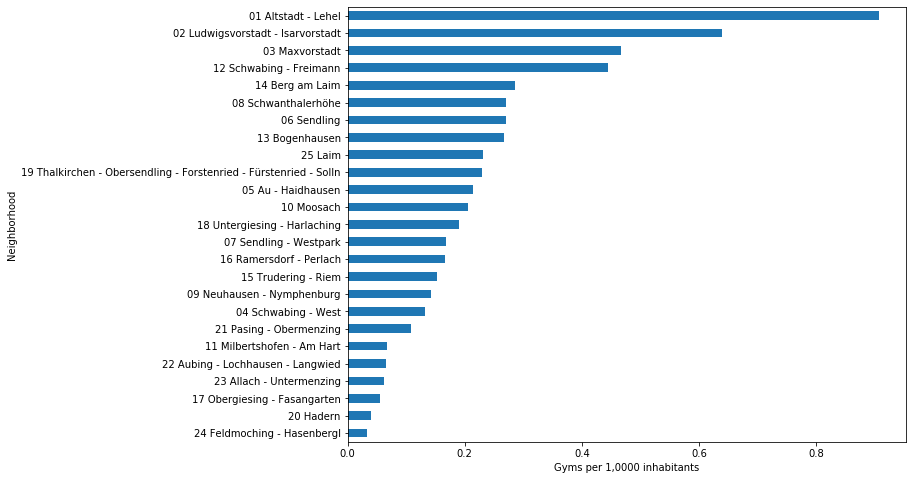

In [50]:
%matplotlib inline
gym_count = data[['Neighborhood', 'gyms_per_1000pop']].sort_values('gyms_per_1000pop')
gym_count.set_index('Neighborhood', inplace=True)
gym_count.plot(kind='barh', legend=None,  sharey = False, figsize=(10,8))
plt.xlabel('Gyms per 1,0000 inhabitants')
plt.show()

##### 3.2. Clustering

Clustering uses the 10 Population key figures (e.g. birthrate, average age, etc.)  
Not necessary data columns can be dropped for the k-means algorithm:

In [51]:
# drop columns which are not necessary for clustering
df = data.drop(columns = ['NeighborhoodID', 'Neighborhood', 'Population', 'km2', 'gym_count', 'women_gym_count', 'gyms_per_1000pop', 'gyms_per_km2'])
df.head()

,properties.name,Latitude,Longitude,Population_per_km2,Age_Average,single_share,women_percentage,birthrate,ageing_idx,youth_idx,unemploy_rate,welfare_receip_rate,immi_rate
0,Altstadt-Lehel,48.137828,11.574582,6652,41.7,64.8,49.7,11.2,161.3,13.9,2.1,2.0,16.4
1,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809,11731,39.0,64.7,48.5,11.5,107.2,13.4,3.0,3.5,16.1
2,Maxvorstadt,48.146570,11.571445,11939,38.6,68.9,49.9,12.2,138.7,10.9,2.5,2.4,16.7
3,Schwabing-West,48.164417,11.570364,15646,40.8,61.6,52.6,11.1,148.6,15.7,2.5,2.7,18.2
4,Au-Haidhausen,48.128753,11.590536,14441,40.1,60.3,51.3,13.7,112.1,16.9,3.0,3.4,17.5


Scale the X - data:

In [53]:
from sklearn.preprocessing import StandardScaler

X = df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

Determine the clusters:

In [54]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 1 2 2 1 1 4 1 2 0 0 1 4 1 0 0 1 4 4 4 3 3 3 0 4]


Add the labels to the Dataframe:

In [55]:
data=pd.concat([pd.DataFrame(labels, columns=['Label']), data], axis=1)
data.head()

,Label,NeighborhoodID,Neighborhood,properties.name,Latitude,Longitude,Population,km2,Population_per_km2,Age_Average,single_share,women_percentage,birthrate,ageing_idx,youth_idx,unemploy_rate,welfare_receip_rate,immi_rate,gym_count,women_gym_count,gyms_per_1000pop,gyms_per_km2
0,2,1,01 Altstadt - Lehel,Altstadt-Lehel,48.137828,11.574582,20926,3.1,6652,41.7,64.8,49.7,11.2,161.3,13.9,2.1,2.0,16.4,19,0,0.907961,6.129032
1,1,2,02 Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,48.131771,11.555809,51632,4.4,11731,39.0,64.7,48.5,11.5,107.2,13.4,3.0,3.5,16.1,33,1,0.639139,7.500000
2,2,3,03 Maxvorstadt,Maxvorstadt,48.146570,11.571445,51311,4.3,11939,38.6,68.9,49.9,12.2,138.7,10.9,2.5,2.4,16.7,24,0,0.467736,5.581395
3,2,4,04 Schwabing - West,Schwabing-West,48.164417,11.570364,68265,4.4,15646,40.8,61.6,52.6,11.1,148.6,15.7,2.5,2.7,18.2,9,0,0.131839,2.045455
4,1,5,05 Au - Haidhausen,Au-Haidhausen,48.128753,11.590536,60937,4.2,14441,40.1,60.3,51.3,13.7,112.1,16.9,3.0,3.4,17.5,13,1,0.213335,3.095238


Visualize the Clusters:

In [62]:
map_clusters = folium.Map(location=munich_city_center, zoom_start=11)
folium.GeoJson(
    munich_districts,
    name='geojson'
).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['Neighborhood'], data['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

##### 3.3. Calculate the average key figures per cluster

In [56]:
cluster_avg = data.groupby('Label').mean()
cluster_avg.reset_index(level=0, inplace=True)
cluster_avg = cluster_avg[['Label', 'gym_count', 'gyms_per_1000pop', 'gyms_per_km2']]
cluster_avg.columns=(['Label', 'avg_gym_count', 'avg_gyms_per_1000pop', 'avg_gyms_per_km2'])
cluster_avg

,Label,avg_gym_count,avg_gyms_per_1000pop,avg_gyms_per_km2
0,0,9.600000,0.124690,0.575398
1,1,16.428571,0.311417,3.019720
2,2,16.500000,0.412410,3.710288
3,3,4.333333,0.077949,0.233952
4,4,13.333333,0.187926,1.232210


##### 3.4. & 3.5 Calculate the key figure deviation for each Neighborhood and calculated the mean average of these deviations
The final key figure is called *'gym_index'* and added to the DataFrame:

In [57]:
gym_results = pd.merge(data[['Label', 'Neighborhood', 'Latitude', 'Longitude', 'properties.name', 'gym_count', 'women_gym_count', 'gyms_per_1000pop', 'gyms_per_km2']], cluster_avg, how='left', on = 'Label')
gym_results['gym_index'] = ((gym_results['gym_count']/gym_results['avg_gym_count']+
                            gym_results['gyms_per_1000pop']/gym_results['avg_gyms_per_1000pop']+
                            gym_results['gyms_per_km2']/gym_results['avg_gyms_per_km2'])/3)-1
gym_results

,Label,Neighborhood,Latitude,Longitude,properties.name,gym_count,women_gym_count,gyms_per_1000pop,gyms_per_km2,avg_gym_count,avg_gyms_per_1000pop,avg_gyms_per_km2,gym_index
0,2,01 Altstadt - Lehel,48.137828,11.574582,Altstadt-Lehel,19,0,0.907961,6.129032,16.500000,0.412410,3.710288,0.668339
1,1,02 Ludwigsvorstadt - Isarvorstadt,48.131771,11.555809,Ludwigsvorstadt-Isarvorstadt,33,1,0.639139,7.500000,16.428571,0.311417,3.019720,1.181575
2,2,03 Maxvorstadt,48.146570,11.571445,Maxvorstadt,24,0,0.467736,5.581395,16.500000,0.412410,3.710288,0.364334
3,2,04 Schwabing - West,48.164417,11.570364,Schwabing-West,9,0,0.131839,2.045455,16.500000,0.412410,3.710288,-0.527858
4,1,05 Au - Haidhausen,48.128753,11.590536,Au-Haidhausen,13,1,0.213335,3.095238,16.428571,0.311417,3.019720,-0.166214
5,1,06 Sendling,48.118012,11.539083,Sendling,11,2,0.270390,2.820513,16.428571,0.311417,3.019720,-0.176049
6,4,07 Sendling - Westpark,48.118031,11.519333,Sendling-Westpark,10,0,0.168390,1.282051,13.333333,0.187926,1.232210,-0.104503
7,1,08 Schwanthalerhöhe,48.134230,11.539034,Schwanthalerhöhe,8,0,0.270865,3.809524,16.428571,0.311417,3.019720,-0.127237
8,2,09 Neuhausen - Nymphenburg,48.154222,11.531517,Neuhausen-Nymphenburg,14,1,0.142103,1.085271,16.500000,0.412410,3.710288,-0.504815
9,0,10 Moosach,48.179895,11.510571,Moosach,11,0,0.204987,0.990991,9.600000,0.124690,0.575398,0.504023


Show Barchart for the final gym index.  
Negative index values indicate Neigborhoods with high potential of market request for fitness center (e.g. 'Obergiesing - Fasangarten').   
Positive index values indicate saturation of the Market (e.g. 'Ludwigsvorstadt - Isarvorstadt').

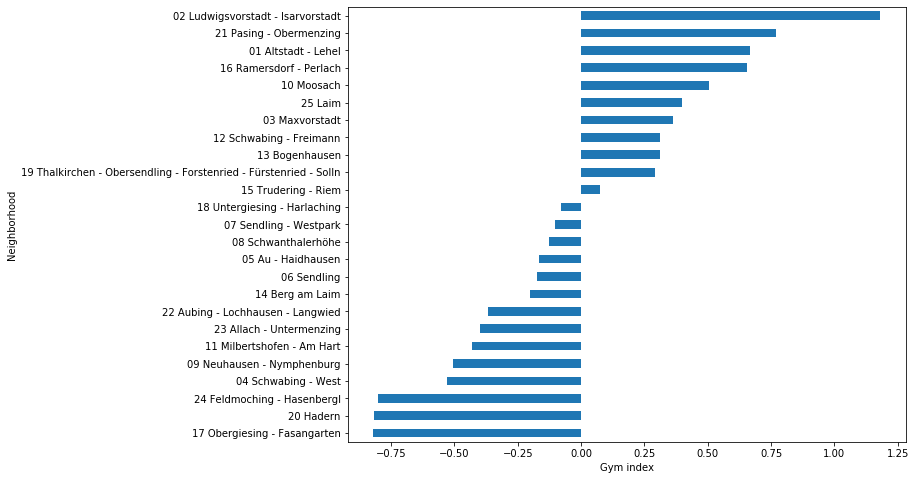

In [60]:
%matplotlib inline
viz = gym_results[['Neighborhood', 'gym_index']].sort_values('gym_index')
viz.set_index('Neighborhood', inplace=True)
viz.plot(kind='barh', legend=None,  sharey = False, figsize=(10,8))
plt.xlabel('Gym index')
plt.show()

Show Choropleth Map for the Gym index market potential:

In [64]:
map_result = folium.Map(location=munich_city_center, zoom_start=11)
map_result.choropleth(
    geo_data=open('muenchen_city_districts.geojson', 'r', encoding="utf-8").read(),
    data=gym_results,
    columns=['properties.name', 'gym_index'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Gym index'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, idx in zip(gym_results['Latitude'], gym_results['Longitude'], gym_results['Neighborhood'], gym_results['Label'],  gym_results['gym_index']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Gym-Idx ' + str(idx), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_result)

map_result

<a id = 'item4'></a>
## 4. Results and Discussion

Based on the final gym Index Neighborhoods with high market potential can be identified easily. Also interesting is the location of such Neighborhoods given by the map. The 3 neighborhoods with the highest potential are located in the outskirts (Districts 17, 20, 24):

In [68]:
gym_results[['Neighborhood', 'gym_index']].sort_values('gym_index').head()

,Neighborhood,gym_index
16,17 Obergiesing - Fasangarten,-0.821498
19,20 Hadern,-0.819708
23,24 Feldmoching - Hasenbergl,-0.802720
3,04 Schwabing - West,-0.527858
8,09 Neuhausen - Nymphenburg,-0.504815


'Schwabing - West' and 'Neuhausen - Nymphenburg' are much closer to the city center and therefore could be also interesting for opening of a new Fitness Center because the population density is higher there:

Lets have a look on the population figures for the five most interesting districts:

<a id = 'item5'></a>
## 5. Conclusion